In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
msoa = gpd.read_file(os.path.join("statistical-gis-boundaries-london","ESRI","MSOA_2011_London_gen_MHW.shp"))

<AxesSubplot:>

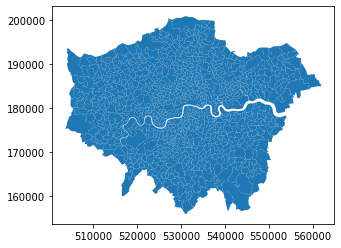

In [3]:
msoa.plot()

In [13]:
df = pd.read_csv('MSOA_centroids_coods_HP_CC_BC.csv')
df

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,x,y,HousingPrice,CC_w,BC_w
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,532482.704,181269.310,948773.00,4.647500,3.020244e+05
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,548312.915,189881.379,291021.25,3.667651,1.712891e+07
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,548454.925,188400.150,316439.50,3.742011,3.840586e+07
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,551008.972,186310.934,333975.75,3.491687,1.734522e+06
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,548667.089,186903.344,325209.75,3.771029,3.587325e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.0,3338,2.5,540690.487,175178.489,517370.75,5.041355,3.818077e+07
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.0,2977,2.2,537700.197,177616.263,486411.50,5.667218,3.741066e+07
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.4,3333,2.2,539747.826,179078.898,536220.50,5.331365,8.996165e+07
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.6,2876,2.3,539775.395,178277.541,559138.75,5.417849,1.165847e+08


<AxesSubplot:>

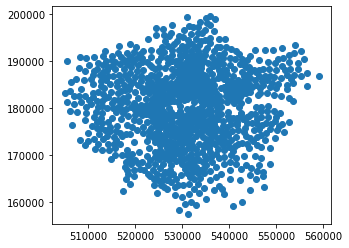

In [14]:
# Convert the df into a GeoDataFrame named gdf
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y, crs='epsg:27700'))
#gdf = gdf.to_crs('epsg:27700')
gdf.plot()

In [20]:
gdf.drop(gdf[((gdf.CC_w.isna()))].index, axis=0, inplace=True)
gdf.drop(gdf[((gdf.BC_w.isna()))].index, axis=0, inplace=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 979 entries, 0 to 982
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MSOA11CD      979 non-null    object  
 1   MSOA11NM      979 non-null    object  
 2   LAD11CD       979 non-null    object  
 3   LAD11NM       979 non-null    object  
 4   RGN11CD       979 non-null    object  
 5   RGN11NM       979 non-null    object  
 6   USUALRES      979 non-null    int64   
 7   HHOLDRES      979 non-null    int64   
 8   COMESTRES     979 non-null    int64   
 9   POPDEN        979 non-null    float64 
 10  HHOLDS        979 non-null    int64   
 11  AVHHOLDSZ     979 non-null    float64 
 12  x             979 non-null    float64 
 13  y             979 non-null    float64 
 14  HousingPrice  979 non-null    float64 
 15  CC_w          979 non-null    float64 
 16  BC_w          979 non-null    float64 
 17  geometry      979 non-null    geometry
dtypes:

In [21]:
g_y = gdf['HousingPrice'].values.reshape((-1,1))
g_y.shape

(979, 1)

In [22]:
g_X = gdf['CC_w'].values.reshape((-1,1))
g_X.shape

(979, 1)

In [23]:
u = gdf['x']
v = gdf['y']
g_coords = list(zip(u,v))
g_coords[0:5]

[(532482.704, 181269.31),
 (548312.915, 189881.379),
 (548454.925, 188400.15),
 (551008.972, 186310.934),
 (548667.089, 186903.344)]

In [24]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_bw

18.0

In [25]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [26]:
gwr_results.params[0:5]

array([[1054469.00661117,  -27850.19905933],
       [ 304793.43193263,    6698.28043269],
       [ 169864.45304443,   40007.06081354],
       [ 883703.28242499, -160944.53107382],
       [ 294008.59055927,    3221.33068525]])

In [27]:
gwr_results.localR2[0:5]

array([[0.05023451],
       [0.39475823],
       [0.34637832],
       [0.65069609],
       [0.40439445]])

In [28]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 979
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       112895532882237.812
Log-likelihood:                                                  -13857.172
AIC:                                                              27718.344
AICc:                                                             27720.369
BIC:                                                           112895532875509.672
R2:                                                                   0.209
Adj. R2:                                                              0.209

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---

In [29]:
# Add GWR parameters to GeoDataframe
gdf['gwr_x0'] = gwr_results.params[:,0]
gdf['gwr_x1'] = gwr_results.params[:,1]

In [30]:
# Obtain t-values filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [31]:
gwr_filtered_t[0:5]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

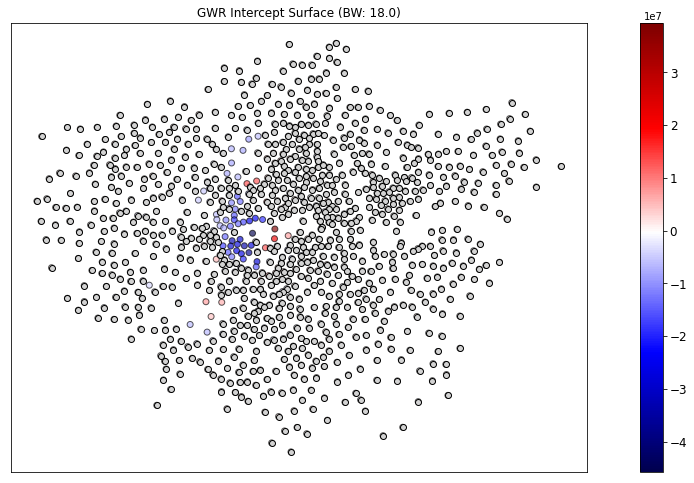

In [32]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = gdf['gwr_x0'].min()
gwr_max = gdf['gwr_x0'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
gdf.plot('gwr_x0', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    gdf[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()